In [13]:
import cv2
import numpy as np
from glob import glob
from PIL import Image
from IPython.display import display, clear_output

# Capture using 14 bit temperature values
ISI only supports raw8, 10, 12 and 16. So we choose 16. In raw12, it bitsifts by4, so the MSB 2 bits are discarded.   

fcc: Y16 


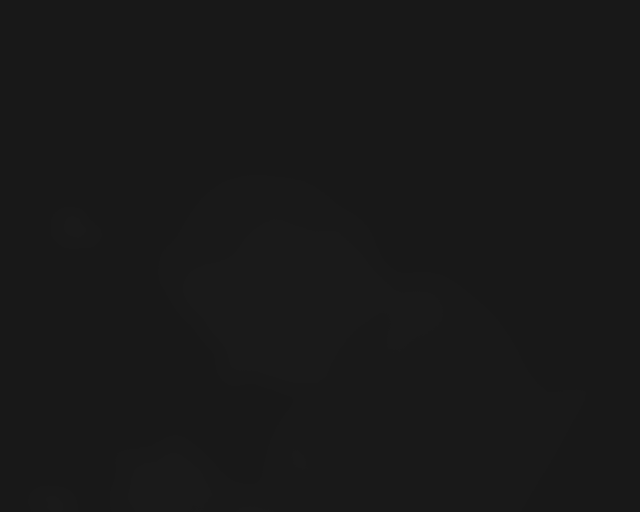

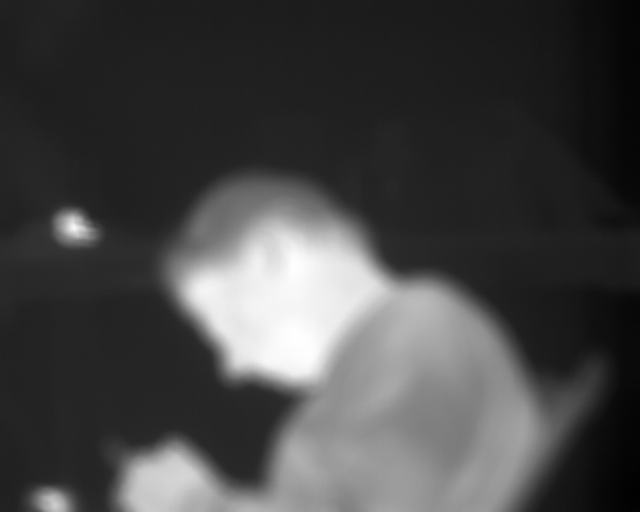

In [ ]:
cap = cv2.VideoCapture(0, cv2.CAP_V4L2)
if not cap.isOpened():
    raise SystemExit("Failed to open camera")

try:
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 512)
    cap.set(cv2.CAP_PROP_CONVERT_RGB, 0)
    cap.set(cv2.CAP_PROP_FPS, 60)
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"Y16 ")) # can get this in gstreamer with "formatGRAY16_LE
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    fcc = "".join([chr((fourcc >> 8*i) & 0xFF) for i in range(4)])
    print(f"fcc: {fcc}")

    ret, img = cap.read()
    if img is None:
        print("something went wrong")
    else:
        display(Image.fromarray(img))
        display(Image.fromarray(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))) # normalise so we can actually see something
finally:
    cap.release()

# Capture using YUV mode
This is the colorized post AGC values. 
The YUV outputs can be safely run though the libcamera RGB convert (via CAP_PROP_CONVERT_RGB prop below), but libcamera outputs BGR, not RGB.
It can also be run through the ISI color conversion: select fourcc RGB3 and you will get the right values. 

fcc: YUYV


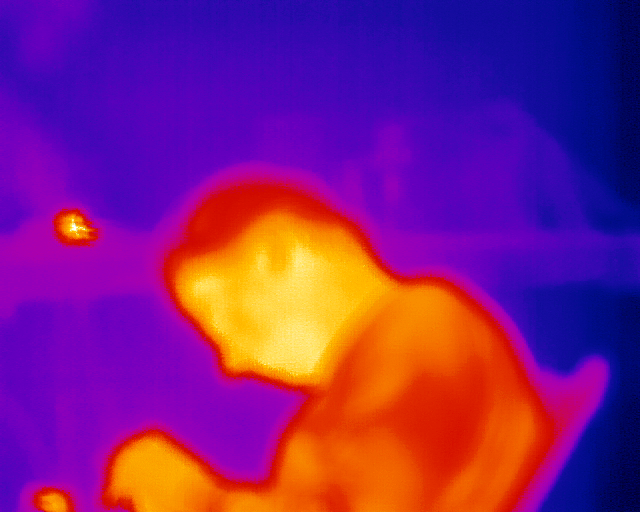

In [ ]:
cap = cv2.VideoCapture(0, cv2.CAP_V4L2)
if not cap.isOpened():
    raise SystemExit("Failed to open camera")

try:
    # Optional: tweak caps
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 512)
    cap.set(cv2.CAP_PROP_CONVERT_RGB, 0)
    cap.set(cv2.CAP_PROP_FPS, 60)
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"YUYV"))
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    fcc = "".join([chr((fourcc >> 8*i) & 0xFF) for i in range(4)])
    print(f"fcc: {fcc}")

    ret, img = cap.read()
    if img is None:
        print("something went wrong")
    else:
        rgb = cv2.cvtColor(img, cv2.COLOR_YUV2RGB_YUYV)   # convert to RGB. libcamera CAP_PROP_CONVERT_RGB (above) gives BGR, not RGB, so it displays incorrecly in jupyter.
        display(Image.fromarray(rgb))
finally:
    cap.release()

# Capture RAW8 mode
This the 8 bit post-AGC values. The same info as the colorized, but more easy to process. 

fcc: GREY


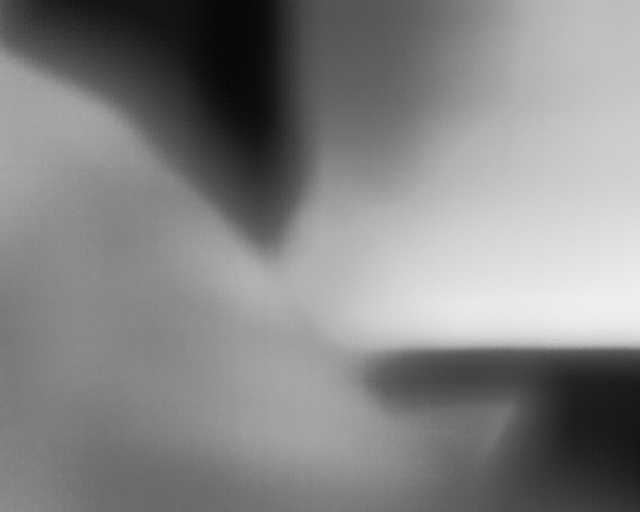

Raw-8 display


In [ ]:
cap = cv2.VideoCapture(0, cv2.CAP_V4L2)
if not cap.isOpened():
    raise SystemExit("Failed to open camera")

try:
    # Optional: tweak caps
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 512)
    cap.set(cv2.CAP_PROP_CONVERT_RGB, 0)
    cap.set(cv2.CAP_PROP_FPS, 60)
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"GREY")) # 8 bit post-AGC values. Can get this from gstreamer with "video/x-raw,format=GRAY8"
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    fcc = "".join([chr((fourcc >> 8*i) & 0xFF) for i in range(4)])
    print(f"fcc: {fcc}")

    ret, img = cap.read()
    if img is None:
        print("something went wrong")
    else:
        display(Image.fromarray(img))
        print("Raw-8 display")
finally:
    cap.release()

# Use 14-bit with Telemetry
Setting res to 640x513 enables the telemetry line. Temperature, spot meter, etc can be retrieved. 

In [ ]:
import struct
cap = cv2.VideoCapture(0, cv2.CAP_V4L2)
if not cap.isOpened():
    raise SystemExit("Failed to open camera")

try:
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 514)
    cap.set(cv2.CAP_PROP_CONVERT_RGB, 0)
    cap.set(cv2.CAP_PROP_FPS, 60)
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"Y16 ")) # can get this in gstreamer with "formatGRAY16_LE
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    fcc = "".join([chr((fourcc >> 8*i) & 0xFF) for i in range(4)])
    print(f"fcc: {fcc}")

    ret, img = cap.read()
    if img is None:
        print("something went wrong")
    else:
        # display(Image.fromarray(img))
        # display(Image.fromarray(cv2.normalize(img[:-2,:], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))) # normalise so we can actually see something
        tel_line = img[-2, :]
        tel_line = tel_line.astype(np.uint8).tobytes()       # telemetry line seems to be bytes packed into the 14-bit values...
        cam_temp = struct.unpack_from('<H', tel_line, 96)[0]
        cam_temp = (cam_temp / 10.0 ) - 273.15
        print(f"Cam temp: {cam_temp}")
finally:
    cap.release()

fcc: Y16 
Cam temp: 33.75


## do straight line correction for temperature assuming target is roughly 20C.
according to Boson datasheet, without radiometry, a target of 20C measures: 
|camera temperature|Counts @20C tagret|
|-|-|
|0|	26500|
|20|23600|
|40|20500|

So, 
$$
C_\text{corr} = C_\text{meas} \times (m,T_\text{sensor} + c)
$$

Gives 
| Target °C |       m |    c |
| :-------- | ------: | ---: |
| 20        | 0.01244 | 1.03 |

But since we're dealing with the left justified 14 bit values and not right justified, we multiply by 4. 

In [ ]:
cam_temp_corr = cam_temp-24.0   # temperature values dont seem correct... applying offset...
corr_factor=(0.01244*cam_temp_corr + 1.03) * 4.0
print(f"correction factor: {corr_factor}")
Ccorr = img[:-2, :] * corr_factor
Ccorr = Ccorr - 27315    # Kelvin to Celsius
Ccorr

(232, 10) (638, 298)


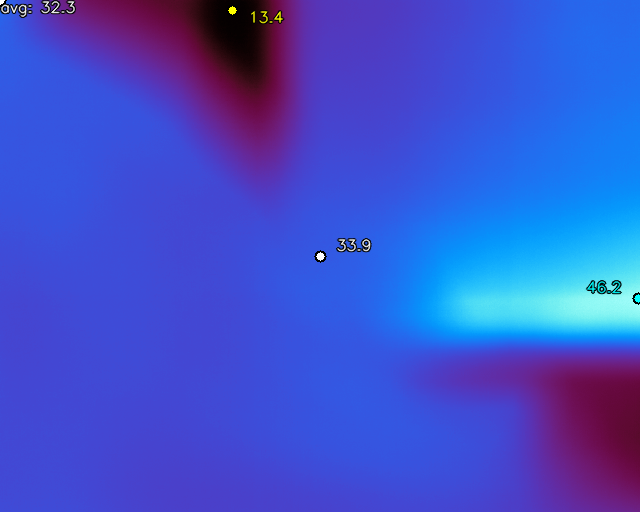

In [ ]:
def draw_val(img, text, pos, color):
    outline_col = (0,0,0)
    cv2.circle(img, pos, 6, outline_col, -1)
    cv2.circle(img, pos, 4, color,       -1)
    tw, th = cv2.getTextSize(text+'  ', cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
    x, y = pos
    h, w = img.shape[:2]
    offset_y = -th//2 if y > th else th # shift down if near top
    offset_x = -tw if x > (w-tw) else 0  # shift left if near right edge
    pos = (x + offset_x, y + offset_y)
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, outline_col, 2, cv2.LINE_AA)
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color      , 1, cv2.LINE_AA)


thermals = Ccorr / 100.0
height, width = thermals.shape
avg = thermals.mean()
tmin = thermals.min()
tmax = thermals.max()
tcen = thermals[height//2, width//2]
# convert to heatmap for display
vis = cv2.normalize(thermals, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
color = cv2.applyColorMap(vis, cv2.COLORMAP_INFERNO)

min_coord = np.unravel_index(np.argmin(thermals), thermals.shape)[::-1]
max_coord = np.unravel_index(np.argmax(thermals), thermals.shape)[::-1]
print(min_coord, max_coord)
draw_val(color, f'avg: {avg:.1f}', (0, 0), (255,255,255))
draw_val(color, f'  {tcen:.1f}', (width//2, height//2), (255,255,255))
draw_val(color, f'  {tmax:.1f}', max_coord, (0,255,255))
draw_val(color, f'  {tmin:.1f}', min_coord, (255,255,0))

display(Image.fromarray(color))